In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.cluster import KMeans
from scipy.spatial import distance
import math
import numpy as np
from numpy.linalg import norm
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
#load and split the data
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.boston_housing.load_data(test_split=0.25)

In [ ]:
# functions that model the rbf layer

# train rbf, we find c (centers) and sigma of neurons
# number of centers = number of neurons in rbf layer
def find_c_sigma(num_neurons,Xtrain):

  kmeans = KMeans(n_clusters=num_neurons, random_state=42).fit(Xtrain)
  c = kmeans.cluster_centers_
  distances = distance.pdist(c,'euclidean') # distances between centers of clusters
  sigma = np.max(distances)/math.sqrt(2*num_neurons)
  
  return c, sigma

# make the rbf layer so we transform the input data  
# take every sample and pass it from neurons -> take transformed data 
def rbf_layer(num_neurons,X,c,sigma):

  out_layer = np.zeros((X.shape[0],num_neurons)) # output of rbf layer
  for i in range(X.shape[0]):
    out_neurons = [] # here will store the output of neurons
    for j in range(num_neurons):
      out =norm(X[i,:]-c[j,:])**2/(2*sigma**2)  
      out=np.exp(-out) # output of neuron j for i sample of Xtrain
      out_neurons.append(out)
    out_layer[i,:] = out_neurons # output of rbf layer, every row corresponds in a transformed sample of Xtrain

  return out_layer




In [ ]:
# define hyperparameters which we want to tune via grid search with 5 Fold cross validation
# take 80% of train size, cause we fit the model only in this and then use the other 20% for validation

length = int(0.8*Xtrain.shape[0]) # size of train data we use
neurons = [int(0.05*length), int(0.15*length), int(0.3*length), int(0.5*length)] # neurons in rbf layer
nh2 = [32, 64, 128, 256] # neurons in hidden layer 2
dropout_prob = [0.2, 0.35, 0.5] # drop out probability

RMSE_mean = [] # mean value of RMSE after cross validation for specific model
hyperparameters = [] # store the hyperparameters, every row corresponds to a model and a RMSE mean value

#doing grid search with 5 Fold cross validation
cv = KFold(n_splits=5)

for n1 in neurons:
  for n2 in nh2:
    for p in dropout_prob:
        RMSE = [] #store the RMSE after training, for every split 
        for train_indices, test_indices in cv.split(Xtrain):
          scaler = StandardScaler() # scaling the data
          # define the train and test data for every iteration of cross validation 
          # fit the scaler only at train set to avoid data leakage
          x_train, x_val = scaler.fit_transform(Xtrain[train_indices]), scaler.transform(Xtrain[test_indices])
          y_train, y_val = ytrain[train_indices], ytrain[test_indices]

          # define the model we test

          # train rbf layer
          c, sigma = find_c_sigma(n1,x_train)
          # transorm the data
          Xtrain_transformed=rbf_layer(n1, x_train, c, sigma)
          Xval_transformed=rbf_layer(n1, x_val, c, sigma)

          # fully connected part
          model = Sequential()
          model.add(Dense(n2, activation='relu',input_shape=(n1,))) 
          model.add(Dropout(p)) # add dropout reguralizer
          model.add(Dense(1, activation='linear')) # output layer
          model.compile(loss=keras.losses.MeanSquaredError(), optimizer = keras.optimizers.SGD(learning_rate=0.001), metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])
          # train fully connected part and then evaluate in validation data
          model.fit(Xtrain_transformed,y_train, batch_size = 32, epochs = 100) 
          ypred = model.predict(Xval_transformed)
          RMSE.append(math.sqrt(mean_squared_error(y_val,ypred)))

        RMSE_mean.append(np.mean(RMSE))
        hyperparameters.append((n1,n2,p))

min_index = np.argmin(RMSE_mean)
print("\nbest model RMSE (mean) is: ",RMSE_mean[min_index])
print("\nHyperparameters of best model: RBF neurons = "+str(hyperparameters[min_index][0])+", nh2 = "+str(hyperparameters[min_index][1])+", p = "+str(hyperparameters[min_index][2])+"")


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 498.9841 - RMSE: 22.3380
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 404.0187 - RMSE: 20.1002
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 284.2353 - RMSE: 16.8593
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 176.2692 - RMSE: 13.2766
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 117.3256 - RMSE: 10.8317
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 98.3656 - RMSE: 9.9179
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 95.4538 - RMSE: 9.7700
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 90.9820 - RMSE: 9.5384
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 90.4268 - RMSE: 9.5093
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - l

65536/57026 [==================================] - 0s 0us/step
Epoch 1/100
10/10 [==============================] - 1s 27ms/step - loss: 582.5045 - RMSE: 24.1351 - val_loss: 528.9805 - val_RMSE: 22.9996
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 532.5711 - RMSE: 23.0775 - val_loss: 472.4805 - val_RMSE: 21.7366
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 458.1086 - RMSE: 21.4035 - val_loss: 381.2756 - val_RMSE: 19.5263
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 344.9196 - RMSE: 18.5720 - val_loss: 261.5147 - val_RMSE: 16.1714
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 223.3375 - RMSE: 14.9445 - val_loss: 159.3307 - val_RMSE: 12.6226
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 140.8783 - RMSE: 11.8692 - val_loss: 108.9839 - val_RMSE: 10.4395
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 103.7540 - RMSE: 10.1860 - va

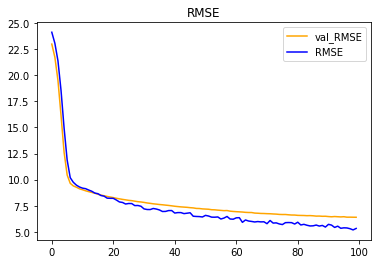

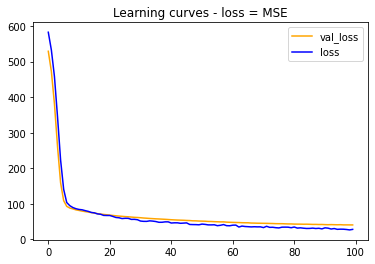

In [ ]:
# training and evaluation of best model

best_params = hyperparameters[min_index][:]
neurons_rbf = best_params[0]
h2_nodes = best_params[1]
dropout = best_params[2]

# load and split the data 
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.boston_housing.load_data(test_split=0.25)
x_train, x_val, y_train, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)


# scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(Xtest)

# define the model 

# train rbf layer
c, sigma = find_c_sigma(neurons_rbf,x_train)

# transorm the data because data pass through rbf layer
Xtrain_transformed=rbf_layer(neurons_rbf, x_train, c, sigma)
Xval_transformed=rbf_layer(neurons_rbf, x_val, c, sigma)
Xtest_transformed=rbf_layer(neurons_rbf, x_test, c, sigma)

# fully connected part
model = Sequential()
model.add(Dense(h2_nodes, activation='relu',input_shape=(neurons_rbf,))) 
model.add(Dropout(dropout)) # add dropout reguralizer
model.add(Dense(1, activation='linear')) # output layer
model.compile(loss=keras.losses.MeanSquaredError(), optimizer = keras.optimizers.SGD(learning_rate=0.001), metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])
# train and validate the fully connected layers
history = model.fit(Xtrain_transformed,y_train, batch_size = 32, epochs = 100, validation_data=(Xval_transformed, yval))

# plots
plt.figure() 
plt.title('RMSE')
plt.plot(history.history['val_RMSE'],color='orange')
plt.plot(history.history['RMSE'],color='blue')
plt.legend(['val_RMSE', 'RMSE'])

plt.figure()
plt.title('Learning curves - loss = MSE')
plt.plot(history.history['val_loss'], color='orange')
plt.plot(history.history['loss'], color='blue')
plt.legend(['val_loss', 'loss'])

# evaluation of model in unseen test data
ypred = model.predict(Xtest_transformed) # prediction of model

R2 = r2_score(ytest,ypred)
MSE = mean_squared_error(ytest,ypred)
MAE = mean_absolute_error(ytest,ypred)

print("\nEvaluation of model in test set: R2 = "+str(R2)+", RMSE = "+str(math.sqrt(MSE))+", MAE = "+str(MAE)+", MSE = "+str((MSE))+"")




          